In [1]:
import scanpy as sc
from scanpy import _utils
import importlib
import warnings
from scanpy import logging as logg
from scipy import sparse
import numpy as np
import pandas as pd
import anndata as ad
from anndata import AnnData
from natsort import natsorted
from collections.abc import Sequence
from typing import TYPE_CHECKING, Literal
import random
import leidenalg
import louvain
import time
try:
    from leidenalg.VertexPartition import MutableVertexPartition
except ImportError:

    class MutableVertexPartition:
        pass

    MutableVertexPartition.__module__ = "leidenalg.VertexPartition"

In [2]:

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Create an AnnData object
adata = sc.AnnData()

# Define the number of cells and genes
n_cells = 100
n_genes = 100


num_cell_types = 2

# Generate a list of random numbers same dim as num_cell_types
random_numbers = np.random.rand(num_cell_types)

# Repeat each string n times
offsets = random.choices(random_numbers, k=n_cells)

# Simulate gene expression data
gene_expression_data = np.random.gamma(shape=1, scale=1, size=(n_cells, n_genes)) 

# Create an AnnData object with the simulated data
adata = sc.AnnData(X=gene_expression_data)


In [3]:
np.random.seed(42)

# Generate gene expression data for 10 genes from a cosine wave
n_cells = adata.shape[0]
n_new_genes = 50
new_gene_names = [f'NewGene_{i}' for i in range(n_genes+1, n_genes+n_new_genes + 1)]


# Create a cosine wave for each gene
gene_expression_data = np.zeros((n_cells, n_new_genes))
for i in range(n_new_genes):
    # phase = np.random.uniform(0, 2 * np.pi)
    if i < n_new_genes/2:
        phase = np.random.uniform(0, 1)
    else:
        phase = np.random.uniform(np.pi, np.pi+1)
    amp = np.random.uniform(10, 20)
    noise = np.random.normal(0, 1, n_cells)
    freq = np.pi*2/n_cells
    gene_expression_data[:, i] = amp  *  np.cos(freq * np.arange(n_cells) + phase ) + (np.array(offsets)*8)
    


# Create a new AnnData object for the new genes
new_genes_adata = ad.AnnData(X=gene_expression_data, var=pd.DataFrame(index=new_gene_names))

# Concatenate the new genes with the existing adata
adata2 = ad.concat([adata, new_genes_adata], axis = 1)

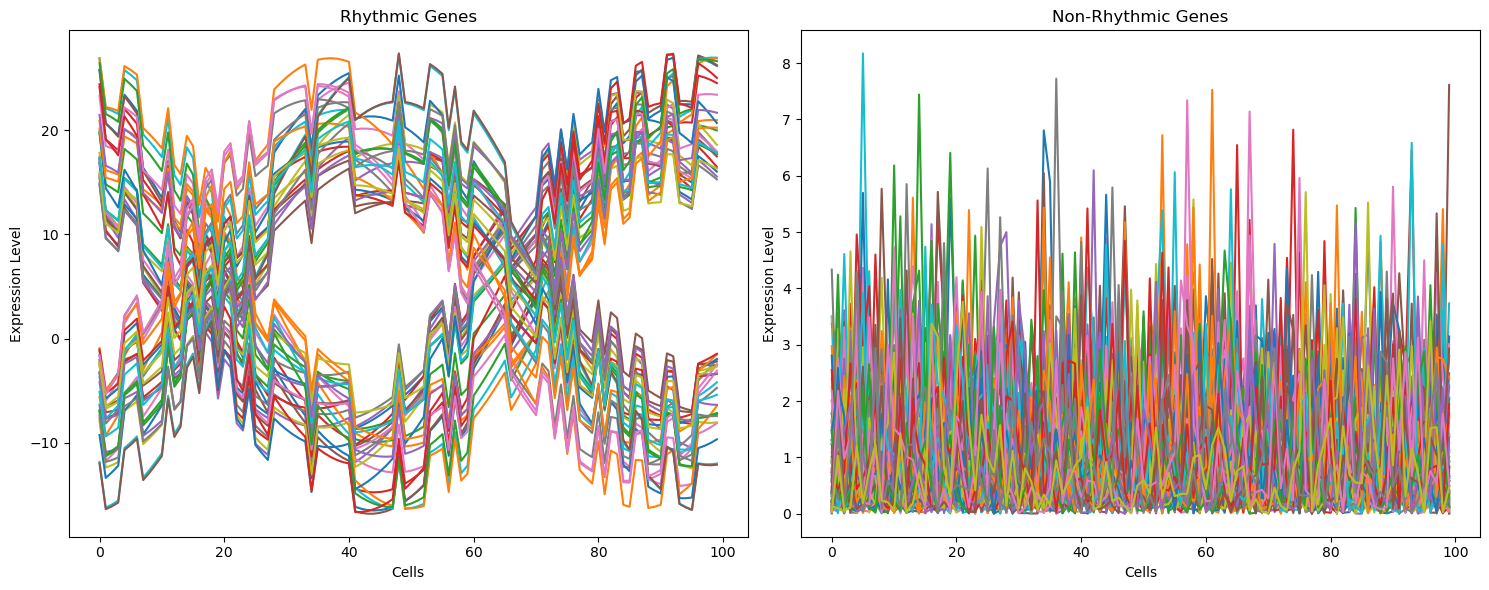

In [4]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot rhythmic genes
axes[0].set_title('Rhythmic Genes')
for i in range(n_genes, n_genes+n_new_genes):
    axes[0].plot( adata2.X[:, i], label=f'Gene_{i + 1}')
axes[0].set_xlabel('Cells')
axes[0].set_ylabel('Expression Level')

# Plot non-rhythmic genes
axes[1].set_title('Non-Rhythmic Genes')
for i in range(0, n_genes-1):
    axes[1].plot(adata2.X[:, i], label=f'Gene_{i + 1}')
axes[1].set_xlabel('Cells')
axes[1].set_ylabel('Expression Level')
#axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
cell_identities = [f'batch_{i:.2f}' for i in offsets]
# Number of times each string should be repeated
# n = int(n_cells/num_cell_types)

# # Repeat each string n times
# result = [s for s in strings for _ in range(n)]
# cell_identities = result + result
# cell_identities = cell_identities[0:n_cells]
assert(len(cell_identities) == n_cells)

/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt

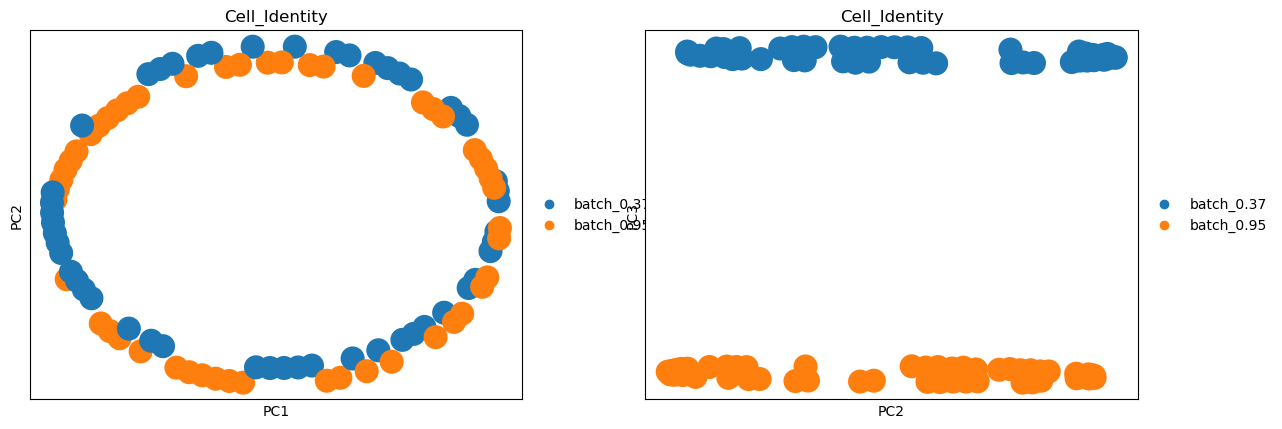

/opt/miniconda3/envs/native/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Perform PCA
sc.tl.pca(adata2)

# Generate random cell identities
#cell_identities = np.random.choice(['Type_A', 'Type_B', 'Type_C'], size=adata2.shape[0])

# # Determine quantiles based on PC3 values
# quantiles = np.percentile(adata2.obsm['X_pca'][:, 2], [0, 25, 50, 75, 100])
# pd.cut(adata2.varm['PCs'][:, 2], bins=[-np.inf] + list(quantiles) + [np.inf], labels=['Type_A', 'Type_B', 'Type_C', 'Type_D', 'Type_E','Type_F'])

# # Assign cell identities based on quantiles
# cell_identities = pd.cut(adata2.obsm['X_pca'][:, 2], bins=[-np.inf] + list(quantiles) + [np.inf], labels=['Type_A', 'Type_B', 'Type_C', 'Type_D', 'Type_E','Type_F'])

#Make cell identities on distant side of clock

# Add the 'Cell_Identity' column to adata.obs
adata2.obs['Cell_Identity'] = cell_identities
adata2.obs['time'] = np.arange(0, n_cells)
# Specify the PCs you want to plot (e.g., PC2, PC3)
pcs_to_plot = ['1,2', '2,3']

# Plot PCA for the selected PCs
sc.pl.pca(adata2, color='Cell_Identity', components=pcs_to_plot, show=True)
# Preprocess the data (e.g., log-transform and scale)
sc.pp.scale(adata2)

# Calculate the neighborhood graph
sc.pp.neighbors(adata2, n_neighbors=4, n_pcs=10)  # Adjust parameters as needed


In [7]:
from random import randint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import igraph
def _plot(g, membership=None, draw = "kk"):
    layouts = ["circle", "drl", "fr", "kk", "fr3d", "kk3d", "large", "lgl", "random", "rt", "tree", "rt_circular", "sphere"]
    if draw not in layouts:
        print("sorry, {} not viable layout option.".format(draw))
        return
    if membership is not None:
        gcopy = g.copy()
        edges = []
        edges_colors = []
        for edge in g.es():
            if membership[edge.tuple[0]] != membership[edge.tuple[1]]:
                edges.append(edge)
                edges_colors.append("gray")
            else:
                edges_colors.append("black")
        gcopy.delete_edges(edges)
        layout = gcopy.layout(draw)
        g.es["color"] = edges_colors
    else:
        layout = g.layout(draw)
        g.es["color"] = "gray"
    visual_style = {}
    visual_style["vertex_label_dist"] = 0
    visual_style["vertex_shape"] = "circle"
    visual_style["edge_color"] = g.es["color"]
    # visual_style["bbox"] = (4000, 2500)
    visual_style["vertex_size"] = 15
    visual_style["layout"] = gcopy.layout(draw)
    visual_style["bbox"] = (1024, 768)
    visual_style["margin"] = 40
    #visual_style["edge_label"] = g.es["weight"]
    for vertex in g.vs():
        vertex["label"] = vertex.index
    if membership is not None:
        colors = []
        for i in range(0, max(membership)+1):
            colors.append('%06X' % randint(0, 0xFFFFFF))
        for vertex in g.vs():
            vertex["color"] = str('#') + colors[membership[vertex.index]]
        visual_style["vertex_color"] = g.vs["color"]
    fig, ax = plt.subplots()
    igraph.plot(g, target = ax, **visual_style)

In [12]:
#interface my custom clustering with scanpy:
def ccdCluster(
    adata: AnnData,
    emat,
    refmat,
    resolution: float = 1,
    *,
    restrict_to: tuple[str, Sequence[str]] | None = None,
    random_state: _utils.AnyRandom = 0,
    key_added: str = "leidenccd",
    adjacency: sparse.spmatrix | None = None,
    directed: bool | None = None,
    use_weights: bool = True,
    n_iterations: int = -1,
    partition_type: type[MutableVertexPartition] | None = None,
    neighbors_key: str | None = None,
    obsp: str | None = None,
    copy: bool = False,
    flavor: Literal["leidenalg", "ipgraph"] = "leidenalg",
    **clustering_args,
) -> AnnData | None:
    """\
    Cluster cells into subgroups [Traag18]_.

    Cluster cells using the Leiden algorithm [Traag18]_,
    an improved version of the Louvain algorithm [Blondel08]_.
    It has been proposed for single-cell analysis by [Levine15]_.

    This requires having ran :func:`~scanpy.pp.neighbors` or
    :func:`~scanpy.external.pp.bbknn` first.

    Parameters
    ----------
    adata
        The annotated data matrix.
    resolution
        A parameter value controlling the coarseness of the clustering.
        Higher values lead to more clusters.
        Set to `None` if overriding `partition_type`
        to one that doesn’t accept a `resolution_parameter`.
    random_state
        Change the initialization of the optimization.
    restrict_to
        Restrict the clustering to the categories within the key for sample
        annotation, tuple needs to contain `(obs_key, list_of_categories)`.
    key_added
        `adata.obs` key under which to add the cluster labels.
    adjacency
        Sparse adjacency matrix of the graph, defaults to neighbors connectivities.
    directed
        Whether to treat the graph as directed or undirected.
    use_weights
        If `True`, edge weights from the graph are used in the computation
        (placing more emphasis on stronger edges).
    n_iterations
        How many iterations of the Leiden clustering algorithm to perform.
        Positive values above 2 define the total number of iterations to perform,
        -1 has the algorithm run until it reaches its optimal clustering.
        2 is faster and the default for underlying packages.
    partition_type
        Type of partition to use.
        Defaults to :class:`~leidenalg.RBConfigurationVertexPartition`.
        For the available options, consult the documentation for
        :func:`~leidenalg.find_partition`.
    neighbors_key
        Use neighbors connectivities as adjacency.
        If not specified, leiden looks .obsp['connectivities'] for connectivities
        (default storage place for pp.neighbors).
        If specified, leiden looks
        .obsp[.uns[neighbors_key]['connectivities_key']] for connectivities.
    obsp
        Use .obsp[obsp] as adjacency. You can't specify both
        `obsp` and `neighbors_key` at the same time.
    copy
        Whether to copy `adata` or modify it inplace.
    flavor
        Which package's implementation to use.
    **clustering_args
        Any further arguments to pass to :func:`~leidenalg.find_partition` (which in turn passes arguments to the `partition_type`)
        or :meth:`igraph.Graph.community_leiden` from `igraph`.

    Returns
    -------
    Returns `None` if `copy=False`, else returns an `AnnData` object. Sets the following fields:

    `adata.obs['leiden' | key_added]` : :class:`pandas.Series` (dtype ``category``)
        Array of dim (number of samples) that stores the subgroup id
        (``'0'``, ``'1'``, ...) for each cell.

    `adata.uns['leiden']['params']` : :class:`dict`
        A dict with the values for the parameters `resolution`, `random_state`,
        and `n_iterations`.
    """
    if flavor not in {"igraph", "leidenalg"}:
        raise ValueError(
            f"flavor must be either 'igraph' or 'leidenalg', but '{flavor}' was passed"
        )
    igraph_spec = importlib.util.find_spec("igraph")
    if igraph_spec is None:
        raise ImportError(
            "Please install the igraph package: `conda install -c conda-forge igraph` or `pip3 install igraph`."
        )
    if flavor == "igraph":
        if directed:
            raise ValueError(
                "Cannot use igraph's leiden implemntation with a directed graph."
            )
        if partition_type is not None:
            raise ValueError(
                "Do not pass in partition_type argument when using igraph."
            )
    else:
        try:
            import leidenalg

            msg = 'Use of leidenalg is discouraged and will be deprecated in the future.  Please use `flavor="igraph"` `n_iterations=2` to achieve similar results.  `directed` must also be `False` to work with `igraph`\'s implementation.'
            warnings.warn(msg, FutureWarning)
        except ImportError:
            raise ImportError(
                "Please install the leiden algorithm: `conda install -c conda-forge leidenalg` or `pip3 install leidenalg`."
            )
    clustering_args = dict(clustering_args)

    start = logg.info("running Leiden ccd clustering")
    adata = adata.copy() if copy else adata
    # are we clustering a user-provided graph or the default AnnData one?
    if adjacency is None:
        adjacency = _utils._choose_graph(adata, obsp, neighbors_key)
    if restrict_to is not None:
        restrict_key, restrict_categories = restrict_to
        adjacency, restrict_indices = restrict_adjacency(
            adata,
            restrict_key,
            restrict_categories=restrict_categories,
            adjacency=adjacency,
        )
    # Prepare find_partition arguments as a dictionary,
    # appending to whatever the user provided. It needs to be this way
    # as this allows for the accounting of a None resolution
    # (in the case of a partition variant that doesn't take it on input)
    clustering_args["n_iterations"] = n_iterations
    #if resolution is not None:
        #clustering_args["resolution_parameter"] = resolution
    if flavor == "leidenalg":
        directed = True if directed is None else directed
        g = _utils.get_igraph_from_adjacency(adjacency, directed=directed)
        if partition_type is None:
            partition_type = leidenalg.ccdModularityVertexPartition
        if use_weights:
            clustering_args["weights"] = np.array(g.es["weight"]).astype(np.float64)
        clustering_args["seed"] = random_state
        part = leidenalg.find_partition(g, partition_type, emat, refmat, **clustering_args)
    else:
        g = _utils.get_igraph_from_adjacency(adjacency, directed=False)
        if use_weights:
            clustering_args["weights"] = "weight"
        clustering_args.setdefault("objective_function", "modularity")
        with _utils.set_igraph_random_state(random_state):
            part = g.community_leiden(**clustering_args)
    # store output into adata.obs
    groups = np.array(part.membership)
    if restrict_to is not None:
        if key_added == "leidenccd":
            key_added += "_R"
        groups = rename_groups(
            adata,
            key_added=key_added,
            restrict_key=restrict_key,
            restrict_categories=restrict_categories,
            restrict_indices=restrict_indices,
            groups=groups,
        )
    adata.obs[key_added] = pd.Categorical(
        values=groups.astype("U"),
        categories=natsorted(map(str, np.unique(groups))),
    )
    # store information on the clustering parameters
    adata.uns["leidenccd"] = {}
    adata.uns["leidenccd"]["params"] = dict(
        resolution=resolution,
        random_state=random_state,
        n_iterations=n_iterations,
    )
    logg.info(
        "    finished",
        time=start,
        deep=(
            f"found {len(np.unique(groups))} clusters and added\n"
            f"    {key_added!r}, the cluster labels (adata.obs, categorical)"
        ),
    )
    return (adata, g )

emat = adata2.X.T[135:150,:]
correlation_matrix = np.corrcoef(emat.T, rowvar=False)

ccd = leidenalg.calcCCD(correlation_matrix, emat)
print("ccd: {}".format(ccd))
t0 = time.time()
# Perform Louvain clustering
_, G = ccdCluster(adata2, emat, correlation_matrix, partition_type= leidenalg.ccdModularityVertexPartition)  # You can adjust the 'resolution' parameter
t1 = time.time()

total = t1-t0
print("time elapsed: {}".format(total))

ccd: 8.610638924532179
Using partition class:  <class 'leidenalg.VertexPartition.ccdModularityVertexPartition'>
Processing ccdModularityVertexPartition instance
Begin Optimisation


/var/folders/td/r_9nz29j4tjbp3ck1k26xf840000gn/T/ipykernel_98639/468982131.py:117: FutureWarning: Use of leidenalg is discouraged and will be deprecated in the future.  Please use `flavor="igraph"` `n_iterations=2` to achieve similar results.  `directed` must also be `False` to work with `igraph`'s implementation.
  warnings.warn(msg, FutureWarning)


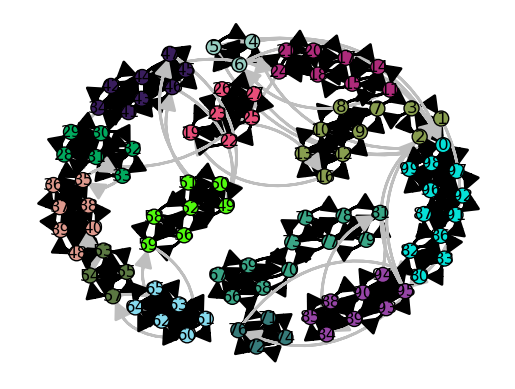

In [9]:
mebership = [int(i) for i in adata2.obs['leidenccd'].to_list()]
_plot(G, mebership, draw = "kk")


/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


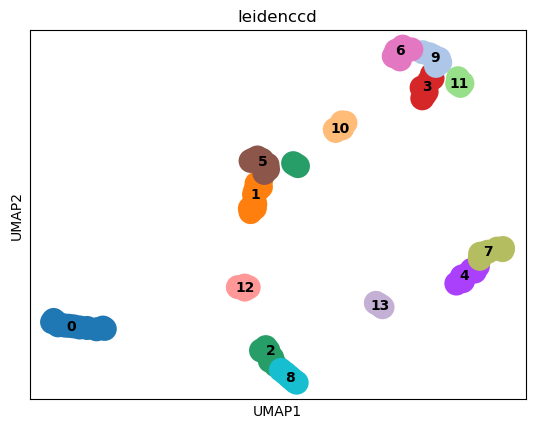

/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


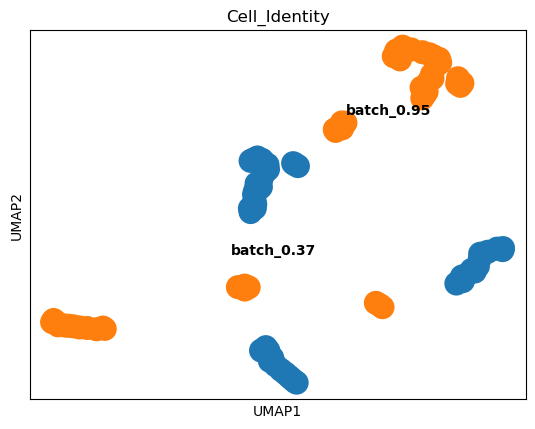

/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


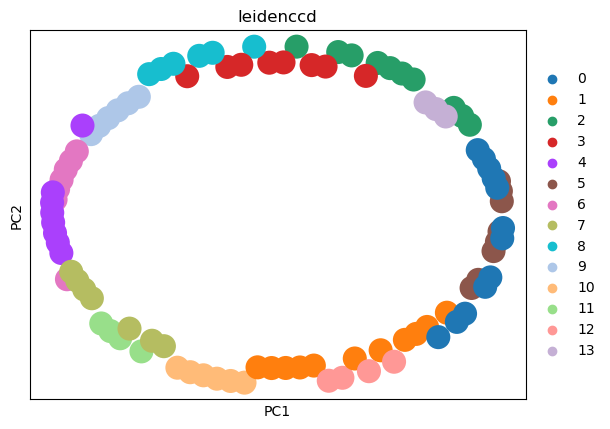

In [10]:
# Assuming you have an 'adata' object with Louvain cluster assignments

# Calculate UMAP
sc.tl.umap(adata2)

# Plot UMAP with Louvain clusters
sc.pl.umap(adata2, color='leidenccd', legend_loc='on data')
sc.pl.umap(adata2, color='Cell_Identity', legend_loc='on data')
sc.pl.pca(adata2, color= 'leidenccd' , show=True)

In [11]:
from sklearn.metrics import adjusted_rand_score
# Extract true labels
true_labels = adata2.obs['Cell_Identity'].values

# Extract Louvain clusters
louvain_clusters = adata2.obs['louvain'].astype(str).values

# Calculate Adjusted Rand Index
ari = adjusted_rand_score(true_labels, louvain_clusters)

# Print the ARI
print("Adjusted Rand Index:", ari)

KeyError: 'louvain'